In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv("./preprocessed_movie_sentences.csv")

In [3]:
dataset.head()

,sentence,rating
0,smart alert thirteen conversation one thing sm...,0
1,color musical bounce warm sea lapping island s...,0
2,massmarket entertainment uncompromising attemp...,0
3,lighthearted french film spiritual quest fashi...,0
4,wife actress ha moment looking comic effect je...,0


In [4]:
dataset.groupby("rating").describe()

sentence                                                             
          count unique                                              top freq
rating                                                                      
0          5000   5000  film prof unrelentingly grim equally engrossing    1
1          5000   4998            sometimes teach child deadly teaching    2

0 for subjective, 1 for objective

In [149]:
dataset["n_words"] = dataset["sentence"].apply(lambda x: len(x.split()))

# SenticNet and POS tagging with spaCy

https://sentic.net/api/

In [6]:
from senticnet5 import senticnet

senticnet['concept_name'] = ['pleasantness_value', 'attention_value', 'sensitivity_value', 'aptitude_value', 'primary_mood', 'secondary_mood', 'polarity_label', 'polarity_value', 'semantics1', 'semantics2', 'semantics3', 'semantics4', 'semantics5']

In [7]:
# polarity value
senticnet['perfect'][7]

'0.867'

In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

https://spacy.io/usage/linguistic-features

token features:

token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop

In [9]:
def adj_polarity(sentence):
    doc = nlp(sentence)
    
    counter = 0
    total_value = 0
    for token in doc:
        if token.pos_ == "ADJ":
            counter += 1
            try:
                total_value += (float(senticnet[token.text][7])) ** 2
            except KeyError as err:
                # print(err) # want to note adjectives that aren't in SenticNet
                pass
            
    return counter, total_value

In [22]:
dataset["n_adj"], dataset["polarity_total"] = zip(*dataset["sentence"].apply(adj_polarity))

In [227]:
dataset["avg_polarity"] = dataset["polarity_total"] / dataset["n_adj"]
dataset["avg_polarity"].fillna(value=0, inplace=True)

In [228]:
dataset.head()

,sentence,rating,n_adj,polarity_total,avg_polarity,strongsubj,weaksubj,n_words
0,smart alert thirteen conversation one thing sm...,0,2,0.860341,0.430171,1,1,8
1,color musical bounce warm sea lapping island s...,0,3,0.770445,0.256815,1,1,13
2,massmarket entertainment uncompromising attemp...,0,0,0.000000,0.000000,1,0,8
3,lighthearted french film spiritual quest fashi...,0,2,0.025301,0.012650,2,1,15
4,wife actress ha moment looking comic effect je...,0,2,0.002809,0.001404,2,0,14


In [229]:
subj_samp = dataset[dataset["rating"] == 0]
obj_samp = dataset[dataset["rating"] == 1]

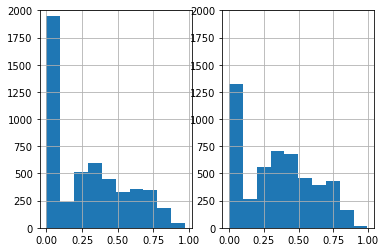

In [232]:
fig, axes = plt.subplots(1, 2)
axes[0].set(ylim=(0, 2000))
axes[1].set(ylim=(0, 2000))

obj_samp["avg_polarity"].hist(ax=axes[0])
subj_samp["avg_polarity"].hist(ax=axes[1])

Not a big difference.

In [23]:
neutral = dataset["avg_polarity"] <= 0.10
extreme = dataset["avg_polarity"] >= 0.80

# MPQA Subjectivity Lexicon

Words are classified as strongly subjective or weakly subjective.

In [55]:
mpqa = pd.read_csv("./subjclueslen1.csv", skipinitialspace=True)
mpqa.head()

,type,word,pos,stemmed,priorpolarity
0,weaksubj,abandoned,adj,n,negative
1,weaksubj,abandonment,noun,n,negative
2,weaksubj,abandon,verb,y,negative
3,strongsubj,abase,verb,y,negative
4,strongsubj,abasement,anypos,y,negative


In [63]:
mpqa.count()

type             8221
word             8221
pos              8221
stemmed          8221
priorpolarity    8221
dtype: int64

In [64]:
mpqa.word.nunique()

6886

In [145]:
def find_subj(sentence):
    doc = nlp(sentence)
    strong = 0
    weak = 0
    
    for token in doc:
        row = mpqa[(mpqa["word"] == token.text) & (mpqa["pos"] == token.pos_.lower())]
        if (row.type == "strongsubj").any():
            strong += 1
        elif (row.type == "weaksubj").any():
            weak += 1
            
    return strong, weak

In [146]:
dataset["strongsubj"], dataset["weaksubj"] = zip(*dataset["sentence"].apply(find_subj))

In [152]:
subj_samp = dataset[dataset["rating"] == 0]
obj_samp = dataset[dataset["rating"] == 1]

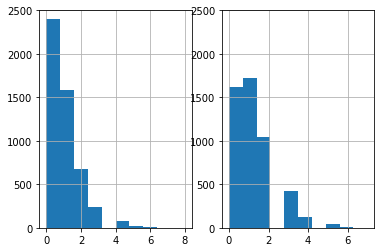

In [155]:
fig, axes = plt.subplots(1, 2)
axes[0].set(ylim=(0, 2500))
axes[1].set(ylim=(0, 2500))

obj_samp["strongsubj"].hist(ax=axes[0])
subj_samp["strongsubj"].hist(ax=axes[1])

# TFIDF

https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

In [215]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [157]:
bow_vector = CountVectorizer(ngram_range=(1,1))
tfidf_vector = TfidfVectorizer()

In [267]:
X = dataset["sentence"]
labels = dataset["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [268]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector), 
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [269]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression\n")
print("Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression

Accuracy: 0.8825
Precision: 0.8808341608738828
Recall: 0.8852295409181636


Will try other classifiers later.

# Adding features to the TFIDF matrix

In [234]:
tfidf_matrix = tfidf_vector.fit_transform(dataset["sentence"])

<10000x20165 sparse matrix of type '<class 'numpy.float64'>'
	with 118207 stored elements in Compressed Sparse Row format>

In [235]:
tfidf_matrix.shape

(10000, 20165)

In [238]:
from scipy.sparse import hstack

combined = hstack((tfidf_matrix, dataset.drop(["sentence", "rating"], axis=1)))
combined.shape

(10000, 20171)

In [273]:
X = combined
labels = dataset["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [263]:
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [264]:
predicted = log.predict(X_test)

# Model Accuracy
print("Logistic Regression\n")
print("Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print("Recall:",metrics.recall_score(y_test, predicted))

Logistic Regression

Accuracy: 0.8785
Precision: 0.8676028084252758
Recall: 0.8862704918032787


This actually seems to do a little worse? We need better-designed features.

# MLPRegressor

Not really sure how this works; just wanted to try something else.

In [270]:
from sklearn.neural_network import MLPRegressor

In [274]:
nn = MLPRegressor()
nn.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

(array([ 18., 137., 284., 312., 312., 303., 324., 222.,  74.,  14.]),
 array([-0.54909643, -0.3286733 , -0.10825018,  0.11217294,  0.33259607,
         0.55301919,  0.77344231,  0.99386543,  1.21428856,  1.43471168,
         1.6551348 ]),
 <a list of 10 Patch objects>)

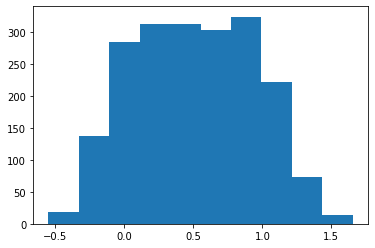

In [286]:
predicted = nn.predict(X_test)

plt.hist(predicted)

In [293]:
discrete = np.array([(xi >= 0.5) for xi in predicted])

In [294]:
print("Accuracy:", metrics.accuracy_score(y_test, discrete))

Accuracy: 0.853
